In [1]:
import numpy as np
import pandas as pd
import datetime
import gc
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
# We define a function for plotting data for a given dataframe based on specified x- axis and y-axis as well as series which shall be used for the legend
def MyScatterplot(df, x_axis, y_axis, color_axis, cmap='Blues', alpha=0.7, gamma=0.2):
    unique_colors = df[color_axis].unique()
    color_mapping = {color: plt.cm.get_cmap(cmap)(i / len(unique_colors)) for i, color in enumerate(unique_colors)}
    colors = df[color_axis].map(color_mapping)

    plt.figure(figsize = (10, 6))
    scatter = plt.scatter(
        df[x_axis],
        df[y_axis],
        c = colors,
        alpha = alpha
    )

    handles = [plt.Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = color_mapping[color], markersize = 8)
               for color in unique_colors]
    plt.legend(handles, unique_colors, title = color_axis)

    plt.title('Scatter Plot of Amount vs Revenue (Colored by {0})'.format(color_axis))
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.grid(True)
    plt.show()

# Loading Data

In [3]:
# Here, I separated environment folder with data folder, so I can work on smaller sample of data when developing and then resue the same code in production.

# folder where data exists
data_folder = './data'
# the environment folder 
env_folder = 'prod' 

file_path = os.path.join(data_folder, env_folder)

# reading previously cleaned data
file_name = 'errands_orders_cleaned.parquet'

In [4]:
# Reading the data from given environment as a datafframe
df = pd.read_parquet( os.path.join(file_path,  file_name))

# Adding Feature

In [5]:
# adding two columns to the dataframe. The first column named 'order:number_of_total_contacts', indicates number of total contacts for each order. The other column which is named 
#'errand:hours_from_order', indicates hours from order creation
df['order:number_of_total_contacts'] = df.groupby('order:id')['errand:id'].transform('count')
df['errand:hours_from_order'] = (df['errand:timestamp'] - df['order:timestamp']).dt.total_seconds() / 3600

# Descriptive Statistics

In [6]:
# We need to aggregate the data for calculating total number of contacts per order
order_level_data = df.groupby('order:id')['order:number_of_total_contacts'].first()

In [7]:
# We want to calculate the average number of customer contacts per order
average_contacts = order_level_data.mean()
print(f"Average number of customer contacts per order: {average_contacts:.2f}")

Average number of customer contacts per order: 2.81


In [8]:
# We want to calculate the distribution of customer contacts per order
contact_distribution = order_level_data.value_counts(normalize=True).sort_index() * 100
print("\nDistribution of customer contacts per order (percentage):")
print(contact_distribution)


Distribution of customer contacts per order (percentage):
1      44.637264
2      21.504596
3      11.539313
4       6.879067
5       4.336485
         ...    
176     0.000098
184     0.000098
185     0.000098
196     0.000098
243     0.000098
Name: order:number_of_total_contacts, Length: 117, dtype: float64


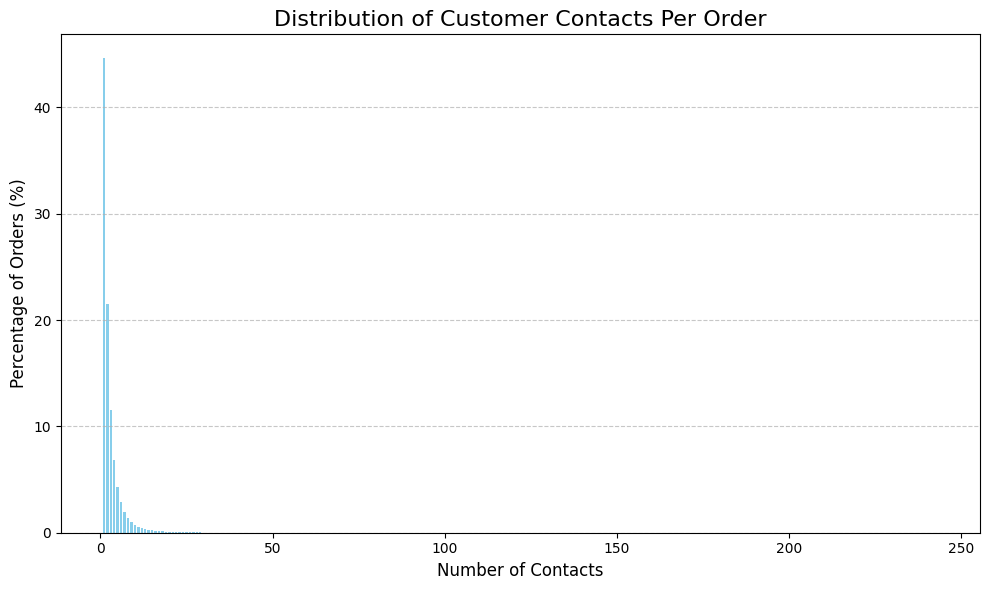

In [9]:
# Visualizing data for showing the distribution of customer contacts per orders
selected_cat = len(contact_distribution)

plt.figure(figsize = (10, 6))

plt.bar(contact_distribution[: selected_cat].index, contact_distribution[ : selected_cat], width = 0.7, color = 'skyblue')


plt.title("Distribution of Customer Contacts Per Order", fontsize = 16)
plt.xlabel("Number of Contacts", fontsize = 12)
plt.ylabel("Percentage of Orders (%)", fontsize = 12)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)


plt.tight_layout()
plt.show()

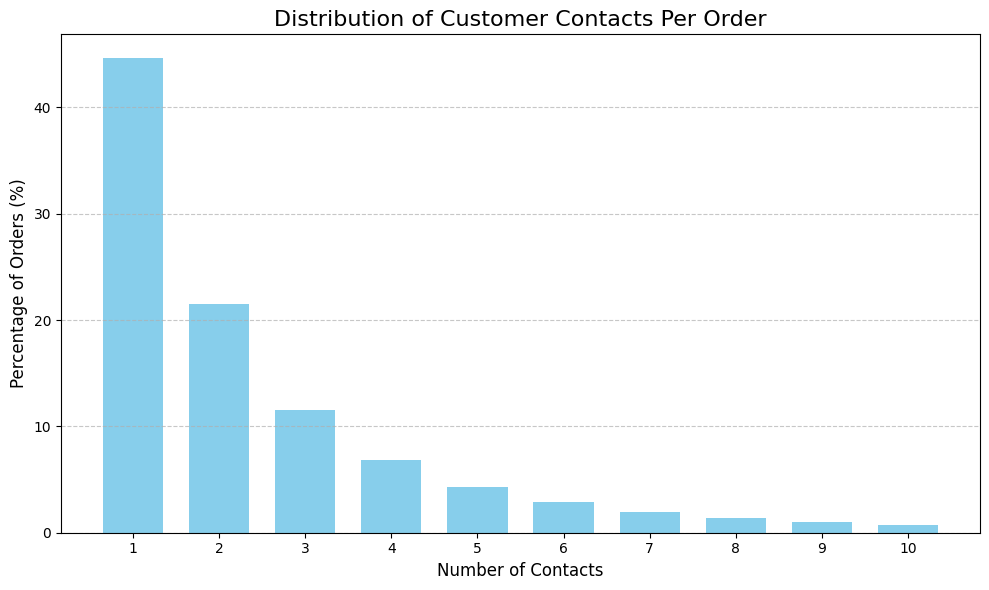

In [10]:
# In the cell above, we noticed that highest percentage of orders contact once. So, in this cell, we plan to zoom a little bit to see the percentage of orders
# contacting one to ten times. 

selected_cat = 10

plt.figure(figsize = (10, 6))

plt.bar(contact_distribution[ :selected_cat].index, contact_distribution[ :selected_cat], width = 0.7, color = 'skyblue')


plt.title("Distribution of Customer Contacts Per Order", fontsize = 16)
plt.xlabel("Number of Contacts", fontsize = 12)
plt.ylabel("Percentage of Orders (%)", fontsize = 12)
plt.xticks(contact_distribution[ :selected_cat].index)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)


plt.tight_layout()
plt.show()

In [11]:
# list of included columns
included_columns = [
    'errand:category', 'errand:type', 'errand:channel', 
    'order:amount', 'order:revenue', 
    'order:booking_system', 'order:num_of_booking_system', 'order:country', 'order:brand', 'order:partner',
    'order:booking_system_type', 'order:customer_group_type',
    'order:device', 'order:client_entry_type', 'order:journey_type_id',
    'order:num_of_pnr', 'order:is_changed', 'order:is_cancelled',
    'order:change_reason', 'order:cancel_reason', 'errand:action_code',
    'errand:action_name',
    'order:number_of_total_contacts', 'errand:hours_from_order'
]

In [12]:
# We extract some of the columns indicated in the list of included columns from the dataframe
df = df[included_columns]

In [13]:
# checking total number of rows
len(df)

2885296

In [14]:
# checking numerical variables
df.describe()

,order:amount,order:revenue,order:num_of_booking_system,order:num_of_pnr,order:is_changed,order:is_cancelled,order:number_of_total_contacts,errand:hours_from_order
count,2.885296e+06,2.885296e+06,2.885296e+06,2.885296e+06,2.885296e+06,2.885296e+06,2.885296e+06,2.885296e+06
mean,9.663437e+02,3.097918e+01,1.114094e+00,1.256527e+00,3.329703e-01,2.201875e-01,6.978131e+00,1.368005e+03
std,1.155737e+03,7.068995e+01,3.415377e-01,5.826753e-01,4.712761e-01,4.143730e-01,9.772018e+00,1.575428e+03
min,-1.034310e+01,-7.281888e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-6.731639e+01
25%,2.785165e+02,8.836222e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.433183e+02
50%,5.986387e+02,9.340000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,7.576164e+02
75%,1.210973e+03,2.421248e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,8.000000e+00,2.077977e+03
max,4.488107e+04,7.036669e+03,5.000000e+00,8.000000e+00,1.000000e+00,1.000000e+00,2.430000e+02,8.453200e+03


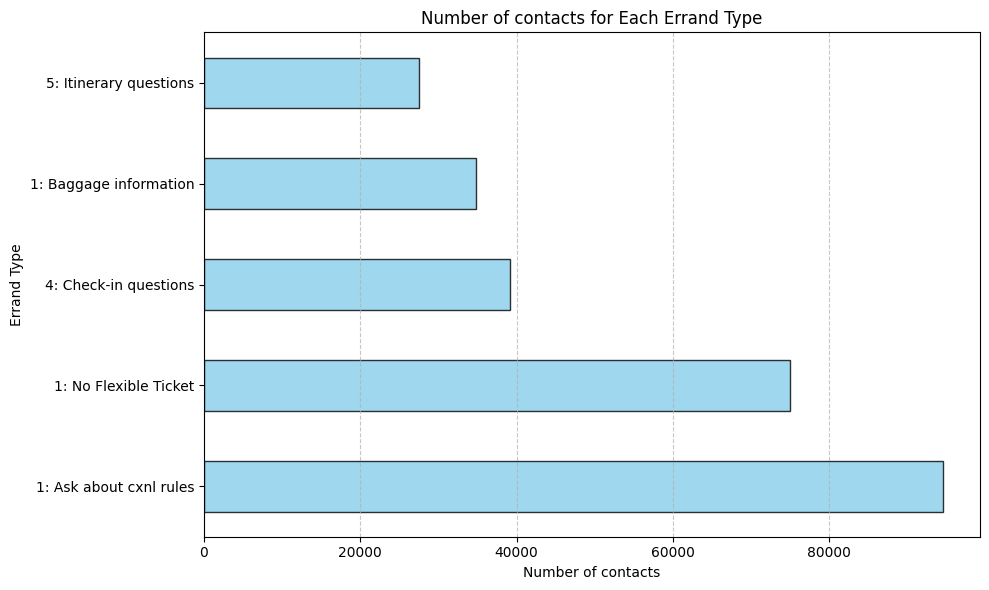

In [15]:
# First, I focus on orders from which only cotacted once, as I assume they are hard to predict,
# however, it might be possible to identify the cause, so we may can avoid them if we are proactive in our services
# e.g., giving more info through some channels to the customers for most frequent errand type that happened.  

plt.figure(figsize=(10, 6))

top_n = 5
df[df['order:number_of_total_contacts']==1]['errand:type'].value_counts()[ :top_n].plot(kind = 'barh', color = 'skyblue', edgecolor = 'black', alpha = 0.8)

plt.title('Number of contacts for Each Errand Type')
plt.xlabel('Number of contacts')
plt.ylabel('Errand Type')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)


plt.tight_layout()
plt.show()

<b><font color='red'>Notes to discuss with Business:</font></b>

Following can be invesgiated if they can reduce the contacts, by performing A/B testing:
* **1: ASK about cxnl rules**, **1: No Flexible Ticket**, **4: Check-in questiond**, **1: Baggage information**, **5: Itinerary questions** How we can elaborate or convey cancellation rules to customers. As these rules are very long, we need further investigation based on more data. If we have recorded voice, we can convert them to text and apply some NLP technique to identify most common topics that customers asked in this category. If those information convey to customer, we may be able to reduce the contacts significantly. 
    


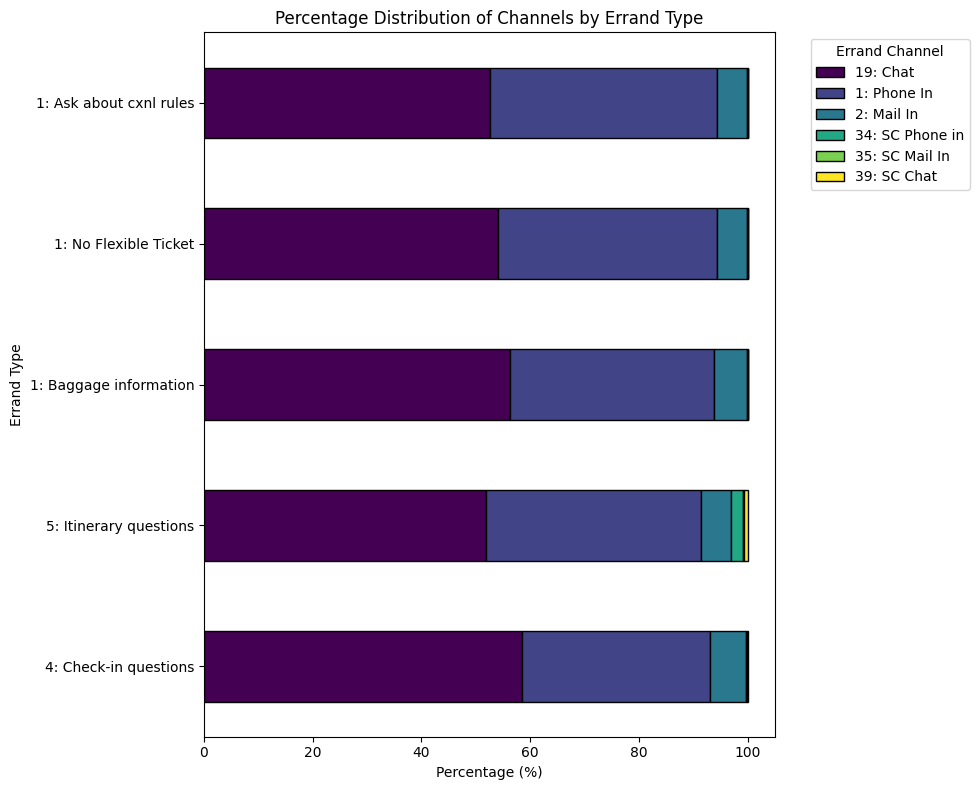

In [16]:
# We filter dataframe which has only one contact per order and is in the five highest errand type. 
# Additinally, we  calculate the percentage of channel used for contacting for each errand type (., Phone, Mail, and etc.)

filtered_df = df[
    (df['order:number_of_total_contacts']==1) & 
    (df['errand:type'].isin(df[df['order:number_of_total_contacts']==1]['errand:type'].value_counts()[ :top_n].index))
]


channel_percentage = (
    filtered_df.groupby(['errand:type', 'errand:channel'])
    .size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / float(x.sum()))
    .reset_index(name='percentage')
)

# channel_percentage = (
#      filtered_df.groupby(['errand:type', 'errand:channel']).size().groupby(level = 0).apply(lambda x: 100 * x / float(x.sum()))
#     .rename_axis(['a', 'errand:type', 'errand:channel']).reset_index(name = 'percentage').drop(columns = ['a'])
# )

pivot_df = channel_percentage.pivot(
    index='errand:type', columns='errand:channel', values='percentage'
).fillna(0)


pivot_df = pivot_df.loc[pivot_df.sum(axis = 1).sort_values(ascending = False).index]

ax = pivot_df.plot(
    kind = 'barh',
    stacked = True,
    figsize = (10, 8),
    edgecolor = 'black',
    colormap = 'viridis'
)

ax.set_xlabel('Percentage (%)')
ax.set_ylabel('Errand Type')
ax.set_title('Percentage Distribution of Channels by Errand Type')
plt.legend(title = 'Errand Channel', bbox_to_anchor = (1.05, 1), loc = 'upper left')


plt.tight_layout()
plt.show()

The above statistics shows that for such analysis, we need to:
* With using NLP techniques for **19: Chat** and **2: Mail**, we can investigate the most repetitive patterns throught the chats and based on that implement chatbot, which customers can get their answer by bot
* Use models like whisper to convert audios to text for **1: Phone In** files

Then, we can combine data with **19: Chat** and if techniquely possible with **2:Mail In**. 
Then, we can apply different analysis. 

This sugegstion also depends on consent that we receive from customer when contacting them via different channel.

In [17]:
# I am excluding data points with only one contact to be able to focuse for cases having more than one contact per order for further analysis.
# This might help to find more insights by reducing the size of data and reduce the computational power needed
df = df[df['order:number_of_total_contacts'] > 3]

In [18]:
# Here, I seprate encoded data from real data, so I can check how different clusters will be look at original data
# Also, due to size of data, I am extracting a small sample which can help me to iterate over my analysis 
df_encoded = df.copy()

df_sample = df.sample(n = 20000, random_state = 42).copy()
df_sample_encoded = df_sample.copy()

# Looking into what to Select for Encoding

In [19]:
# There are three brands for which we have most of contacts, i.e., A, B and D
# maybe we can define four feature, i.e., brand A, B, D, O (Others)
print(df_encoded['order:brand'].value_counts(normalize = True))

# There are three partners for which we have most of contacts, i.e., C, A, B
# maybe we can define four feature, i.e., partner A, B, C, O (Others)
print(df_encoded['order:partner'].value_counts(normalize = True))

# need tp be encoded
print(df_encoded['order:customer_group_type'].value_counts(normalize = True))

# Chat sounds very important channel for customers. 
print(df_encoded['errand:channel'].value_counts(normalize = True))


# In case of possibility for discussing with business people, these might be features to check in the future. 

# print(df_encoded['order:booking_system_type'].value_counts(normalize=True))
# df_encoded['order:device'].value_counts(normalize=True)
# df_encoded['order:client_entry_type'].value_counts(normalize=True)
# df_encoded['order:journey_type_id'].value_counts(normalize=True)
# df_encoded['order:change_reason'].value_counts(normalize=True)
# df_encoded['order:cancel_reason'].value_counts(normalize=True)
# df_encoded['errand:category'].value_counts(normalize=True)
# df_encoded['errand:type'].value_counts(normalize=True)
# df_encoded['errand:action_code'].value_counts(normalize=True)
# df_encoded['errand:action_name'].value_counts(normalize=True)

Brand A    0.540777
Brand B    0.192341
Brand D    0.161717
Brand C    0.035657
Brand E    0.034545
Brand F    0.016517
Brand G    0.009546
Brand H    0.008477
Brand K    0.000187
Brand J    0.000118
Brand I    0.000118
Name: order:brand, dtype: float64
Partner C     0.375476
Partner A     0.330711
Partner B     0.121358
Partner D     0.061329
Partner K     0.010613
                ...   
Partner CF    0.000007
Partner CG    0.000006
Partner BR    0.000004
Partner CO    0.000002
Partner CB    0.000002
Name: order:partner, Length: 78, dtype: float64
SINGLE    0.466287
COUPLE    0.282744
FAMILY    0.171462
GROUP     0.079508
Name: order:customer_group_type, dtype: float64
19: Chat           0.386648
1: Phone In        0.303420
34: SC Phone in    0.097493
39: SC Chat        0.092885
2: Mail In         0.084950
35: SC Mail In     0.034603
Name: errand:channel, dtype: float64


In [20]:
# We encod brands and partners and create one column for each  

def encoding_fun(df_in):
    target_brands = ['Brand A', 'Brand B', 'Brand D']
    target_partners = ['Partner A', 'Partner B', 'Partner C']

    for brand in target_brands:
        df_in[brand] = (df_in['order:brand'] == brand).astype(int)

    df_in['Brand Others'] = (~df_in['order:brand'].isin(target_brands)).astype(int)
    df_in = df_in.drop(columns=['order:brand'])


    for partner in target_partners:
        df_in[partner] = (df_in['order:partner'] == partner).astype(int)

    df_in['Partner Others'] = (~df_in['order:partner'].isin(target_partners)).astype(int)
    df_in = df_in.drop(columns=['order:partner'])

    # 
    df_in = pd.get_dummies(df_in, columns=['order:customer_group_type'], drop_first=False)
    df_in = pd.get_dummies(df_in, columns=['errand:channel'], drop_first=False)
    
    return df_in

In [21]:
# encoding both data and sample data sets
df_encoded = encoding_fun(df_encoded)
df_sample_encoded = encoding_fun(df_sample_encoded)

In [22]:
# extracting the numerical columns
cols_num = df_encoded.describe().columns

In [23]:
# limitting columns to selected ones for both encoded data and sample data sets
df_encoded = df_encoded[cols_num]
df_sample_encoded = df_sample_encoded[cols_num]

In [24]:
# defining scaling func to scale both encoded data and sample data sets
def scaling_fun(df_in):
    # We scale values for 'order:amount', 'order:revenue', and 'errand:hours_from_order'
    #  scaler = StandardScaler()
    scaler = MinMaxScaler()

    df_in[['order:amount']] = scaler.fit_transform(df_in[['order:amount']])
    df_in[['order:revenue']] = scaler.fit_transform(df_in[['order:revenue']])
    df_in[['errand:hours_from_order']] = scaler.fit_transform(df_in[['errand:hours_from_order']])
    
    return df_in

In [25]:
# sclaing both encoded data and sample data sets
df_encoded = scaling_fun(df_encoded)
df_sample_encoded = scaling_fun(df_sample_encoded)

In [26]:
# checking numberical columsn and their disctribition in scaled original data
df_encoded.describe()

,order:amount,order:revenue,order:num_of_booking_system,order:num_of_pnr,order:is_changed,order:is_cancelled,order:number_of_total_contacts,errand:hours_from_order,Brand A,Brand B,...,order:customer_group_type_COUPLE,order:customer_group_type_FAMILY,order:customer_group_type_GROUP,order:customer_group_type_SINGLE,errand:channel_19: Chat,errand:channel_1: Phone In,errand:channel_2: Mail In,errand:channel_34: SC Phone in,errand:channel_35: SC Mail In,errand:channel_39: SC Chat
count,1.631916e+06,1.631916e+06,1.631916e+06,1.631916e+06,1.631916e+06,1.631916e+06,1.631916e+06,1.631916e+06,1.631916e+06,1.631916e+06,...,1.631916e+06,1.631916e+06,1.631916e+06,1.631916e+06,1.631916e+06,1.631916e+06,1.631916e+06,1.631916e+06,1.631916e+06,1.631916e+06
mean,2.487187e-02,1.509453e-01,1.129534e+00,1.291157e+00,4.539296e-01,2.624418e-01,1.086448e+01,1.981001e-01,5.407766e-01,1.923414e-01,...,2.827437e-01,1.714616e-01,7.950777e-02,4.662869e-01,3.866480e-01,3.034200e-01,8.495045e-02,9.749276e-02,3.460350e-02,9.288530e-02
std,2.815055e-02,2.170911e-02,3.667059e-01,6.404460e-01,4.978731e-01,4.399616e-01,1.155737e+01,1.942764e-01,4.983346e-01,3.941399e-01,...,4.503330e-01,3.769120e-01,2.705297e-01,4.988623e-01,4.869820e-01,4.597352e-01,2.788080e-01,2.966277e-01,1.827734e-01,2.902717e-01
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.703549e-03,1.437344e-01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,4.208981e-02,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.614765e-02,1.438839e-01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,1.317367e-01,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.151517e-02,1.488081e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.200000e+01,2.993994e-01,1.000000e+00,0.000000e+00,...,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,5.000000e+00,8.000000e+00,1.000000e+00,1.000000e+00,2.430000e+02,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [27]:
# calculating correlations 
mycorr= df_encoded.corr()

In [28]:
# saving correlations for future analysis
mycorr.to_csv(os.path.join(file_path,'correlations.csv'))

In [29]:
# Identifying significant correlations
# We set a threshold for the correlation and want to filter correlations above the threshold 
threshold = 0.6

related_features = [
    (col1, col2, mycorr.loc[col1, col2])
    for col1 in mycorr.columns
    for col2 in mycorr.columns
    if abs(mycorr.loc[col1, col2]) >= threshold and col1 != col2
]

related_features_df = pd.DataFrame(related_features, columns=["Feature 1", "Feature 2", "Correlation"])

In [30]:
# list of important correlations to consider
set(list(related_features_df["Feature 1"].unique()) + list(related_features_df["Feature 2"].unique()))

{'Brand A', 'Partner A', 'order:num_of_booking_system', 'order:num_of_pnr'}

In [31]:
# selected data for clustering
cols_selected = [] + \
list(df_encoded.columns[df_encoded.columns.str.startswith('Brand')]) + \
list(df_encoded.columns[df_encoded.columns.str.startswith('Partner')]) + \
['order:num_of_booking_system', 'order:num_of_pnr'] + \
['order:amount', 'order:revenue', 'errand:hours_from_order']
# , 'order:number_of_total_contacts'

In [32]:
# checking ccolumsn which are selecetd 
cols_selected

['Brand A',
 'Brand B',
 'Brand D',
 'Brand Others',
 'Partner A',
 'Partner B',
 'Partner C',
 'Partner Others',
 'order:num_of_booking_system',
 'order:num_of_pnr',
 'order:amount',
 'order:revenue',
 'errand:hours_from_order']

# Sample Clustering

In [33]:
# limitting the datasets to selected columns
df_encoded = df_encoded[cols_selected]
df_sample_encoded = df_sample_encoded[cols_selected]

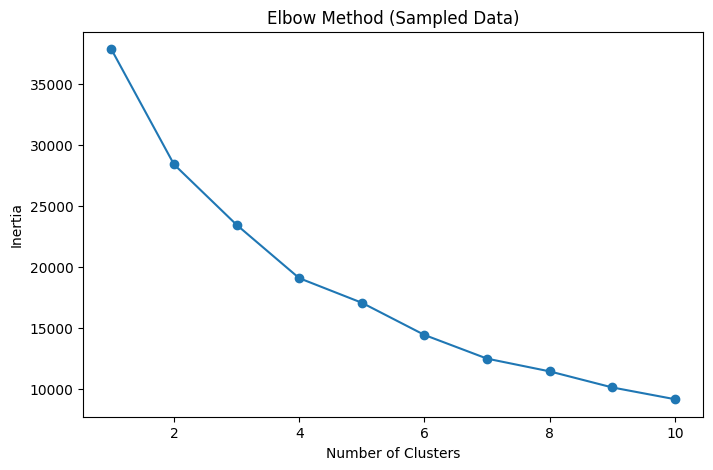

In [34]:
# apply Elbow Method to identify numbers of cluster
# as this is heavy, I only applied it on sample data
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_sample_encoded)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method (Sampled Data)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [35]:
# I apply K-Means with optimal number of clusters
optimal_k = 4  

kmeans = KMeans(n_clusters = optimal_k, random_state = 42)
cluster_labels = kmeans.fit_predict(df_sample_encoded[cols_selected])

In [36]:
# checking number of rows for each cluster
df_sample['cluster'] = cluster_labels
print(df_sample['cluster'].value_counts())

2    6498
3    6343
0    5181
1    1978
Name: cluster, dtype: int64


In [37]:
# I convert centroids to a DataFrame which make it easier for interpretation
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns = cols_selected)  

# I group data by clusters and calculate mean feature values
cluster_summary = df_sample.groupby('cluster').mean()


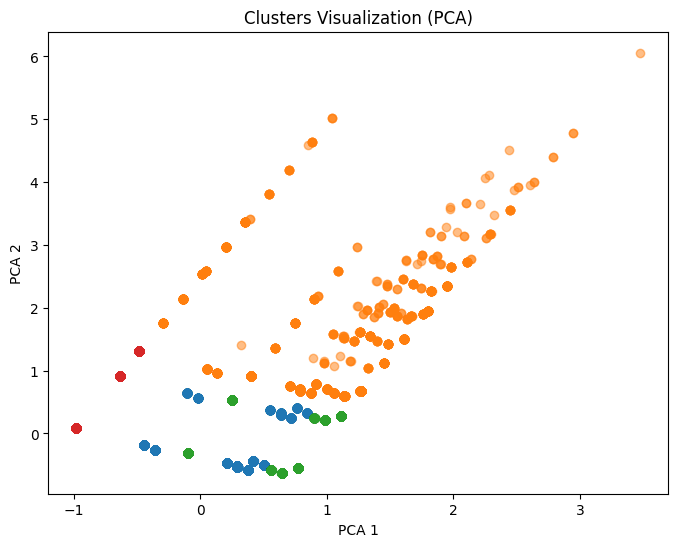

In [38]:
# I convert data to 2  dimensions for visualization using PCA

pca = PCA(n_components = 2)
reduced_data = pca.fit_transform(df_sample_encoded.iloc[:, :-1])  


plt.figure(figsize=(8, 6))

for cluster in range(kmeans.n_clusters):
    plt.scatter(
        reduced_data[df_sample['cluster'] == cluster, 0],
        reduced_data[df_sample['cluster'] == cluster, 1],
        label=f'Cluster {cluster}',
        alpha=0.5
    )


plt.title('Clusters Visualization (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [39]:
# I create a DataFrame for the PCA loadings
components = pca.components_

loadings_df = pd.DataFrame(
    components.T,  
    columns = ['PC1', 'PC2'],  
    index = df_sample_encoded.columns[:-1]  
)

print(loadings_df)

                                  PC1       PC2
Brand A                     -0.563206  0.209783
Brand B                      0.299852 -0.033868
Brand D                      0.172925 -0.110806
Brand Others                 0.090429 -0.065110
Partner A                   -0.509934  0.254482
Partner B                    0.025693 -0.022661
Partner C                    0.375817 -0.136155
Partner Others               0.108424 -0.095666
order:num_of_booking_system  0.154605  0.389530
order:num_of_pnr             0.342237  0.832843
order:amount                -0.000191  0.000040
order:revenue                0.009558 -0.000417


<Figure size 1000x600 with 0 Axes>

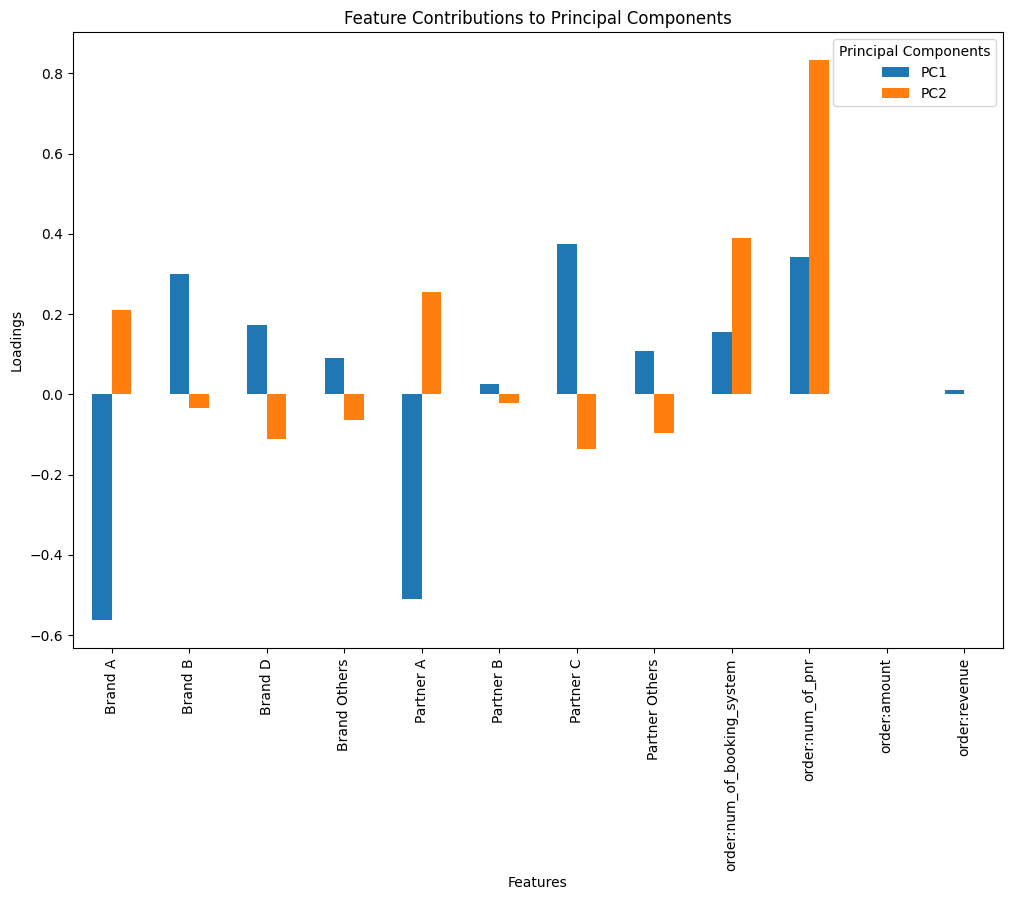

In [40]:
# visualize the contributions of features to the principal components

plt.figure(figsize=(10, 6))

loadings_df.plot(kind='bar', figsize=(12, 8))

plt.title('Feature Contributions to Principal Components')
plt.xlabel('Features')
plt.ylabel('Loadings')
plt.legend(title='Principal Components')
plt.show()

It seems that we shall have different clusters if
* Partner A or C will be selected 
* Choosing different number of PNRs
* Choosing different num of booking system

### Checking result based on Partner A or C 

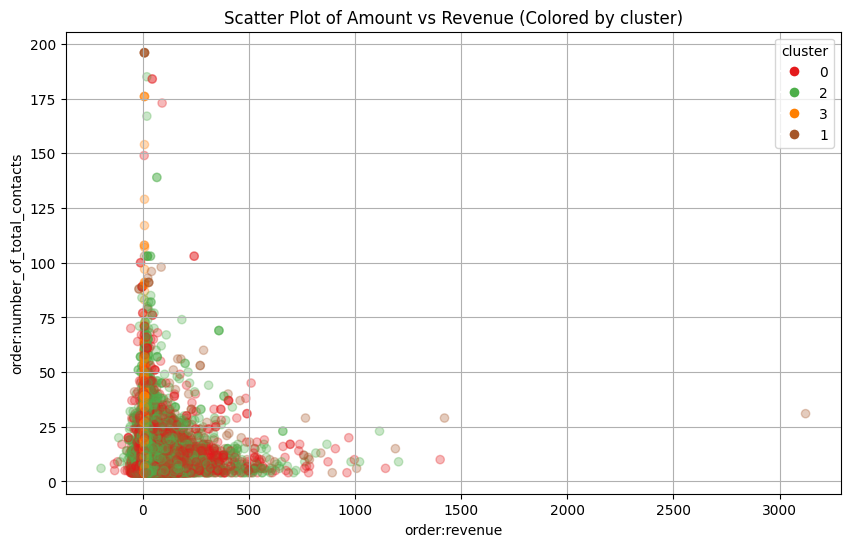

In [41]:
# Plotting data for clusters regardless of the Partner
MyScatterplot(df_sample, 'order:revenue', 'order:number_of_total_contacts', 'cluster', cmap='Set1', alpha=0.3)

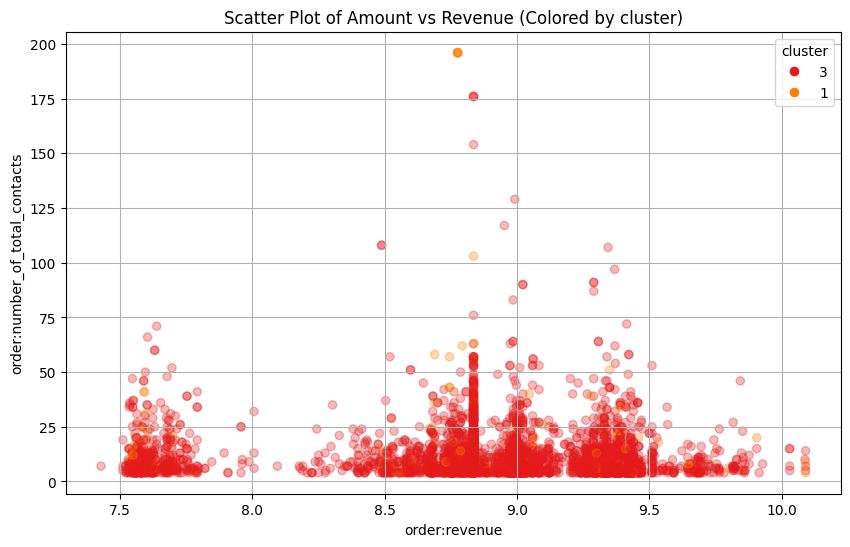

In [42]:
# Plotting data for clusters if Partner A is selected 
MyScatterplot(df_sample[
    (df_sample['order:partner']=='Partner A')
], 'order:revenue', 'order:number_of_total_contacts', 'cluster', cmap='Set1', alpha=0.3)

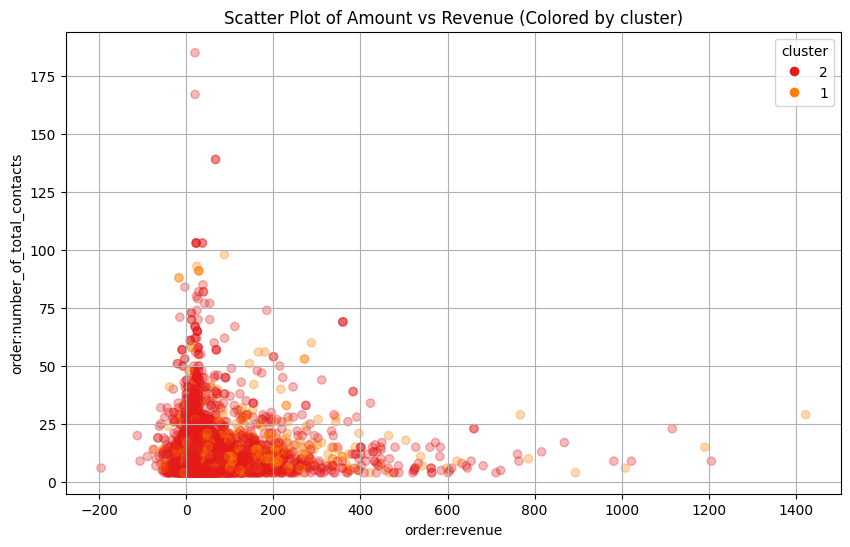

In [43]:
# Plotting data for clusters if Partner C is selected
MyScatterplot(df_sample[
    (df_sample['order:partner']=='Partner C')
], 'order:revenue', 'order:number_of_total_contacts', 'cluster', cmap='Set1', alpha=0.3)

Conclusion: 
   
* Despite the range of number of contacts has not changed much, the revenue differes significantly. This means that we may be able to optimize process for Partner A as they cause the same number of contact

### Checking result based on Number of PNRs

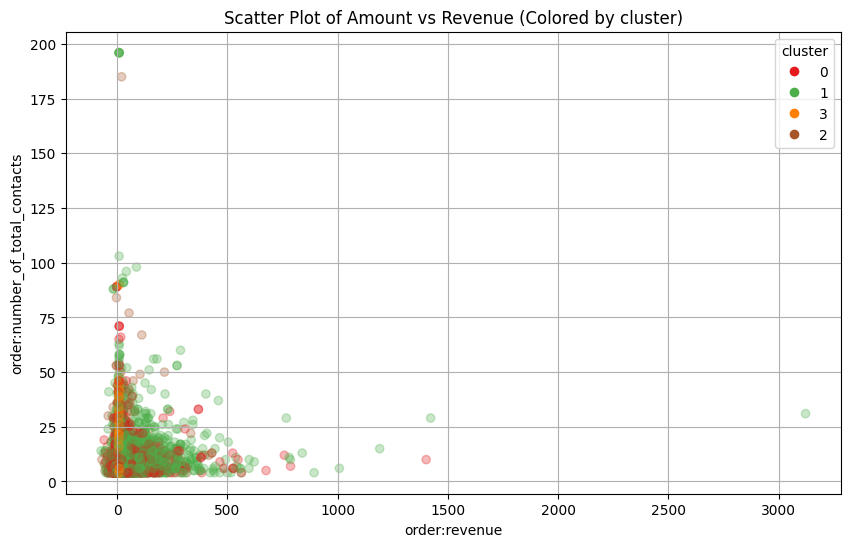

In [44]:
# Plotting data for clusters when PNR numbers are more than 2
MyScatterplot(df_sample[
    (df_sample['order:num_of_pnr']>=2)
], 'order:revenue', 'order:number_of_total_contacts', 'cluster', cmap='Set1', alpha=0.3)

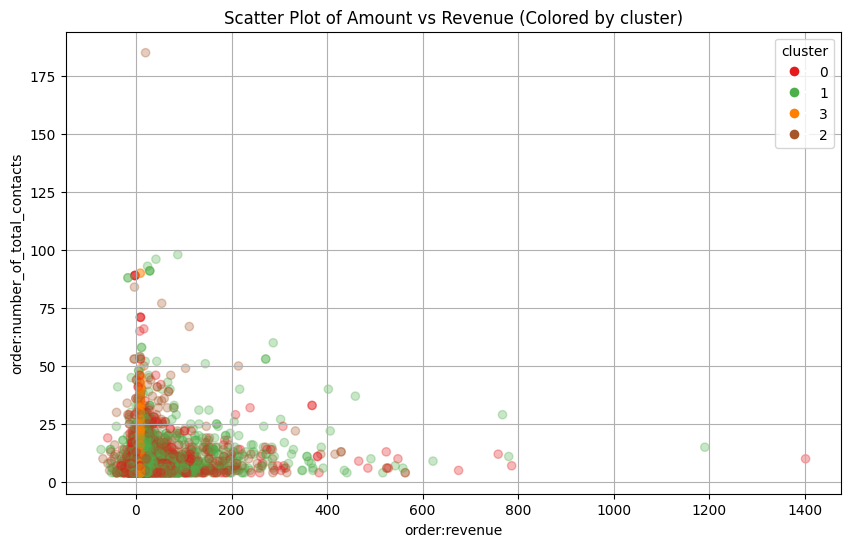

In [45]:
# Plotting data for clusters when PNR numbers are equal to 2
MyScatterplot(df_sample[
    (df_sample['order:num_of_pnr']==2)
], 'order:revenue', 'order:number_of_total_contacts', 'cluster', cmap='Set1', alpha=0.3)

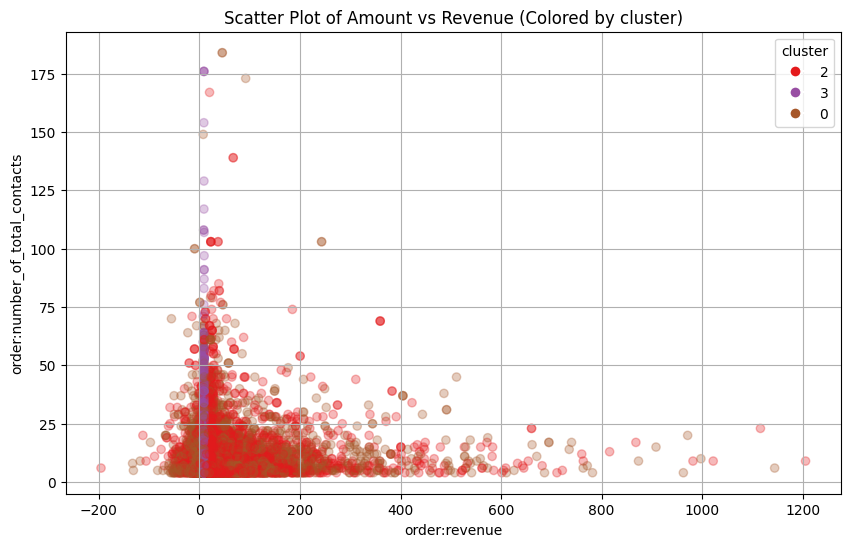

In [46]:
# Plotting data for clusters when PNR numbers are equal to 1
MyScatterplot(df_sample[
    (df_sample['order:num_of_pnr']==1)
], 'order:revenue', 'order:number_of_total_contacts', 'cluster', cmap='Set1', alpha=0.3)

Conclusion:
    
* Might not be a good idea to optimize the process when many PNR are involved as they brings good revenue anyhow

### Checking result based on Number of booking systems

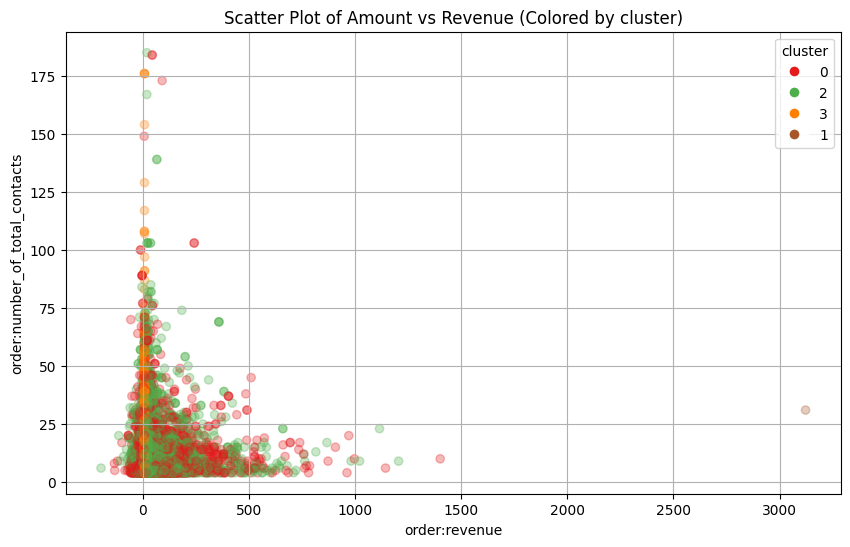

In [47]:
# Plotting data for clusters when only one booking system is used
MyScatterplot(df_sample[
    (df_sample['order:num_of_booking_system']==1)
], 'order:revenue', 'order:number_of_total_contacts', 'cluster', cmap='Set1', alpha=0.3)

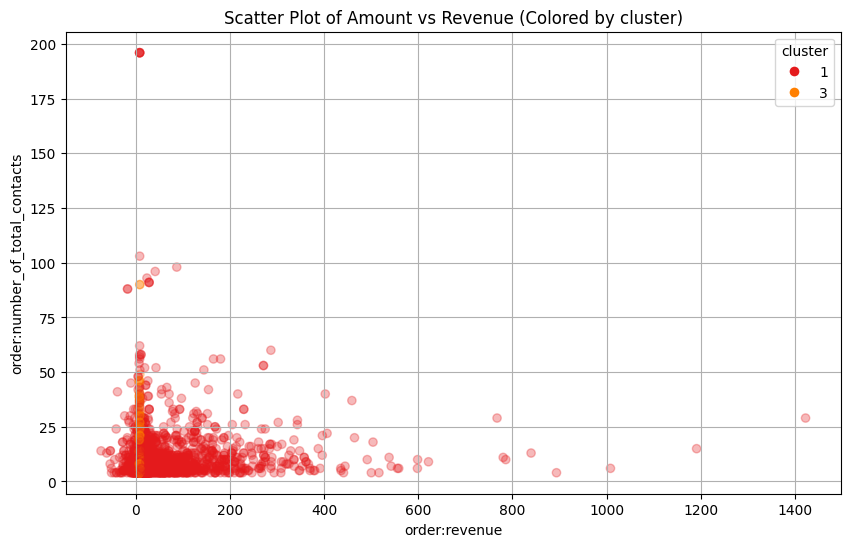

In [48]:
# Plotting data for clusters when more than one booking system is used
MyScatterplot(df_sample[
    (df_sample['order:num_of_booking_system']>1)
], 'order:revenue', 'order:number_of_total_contacts', 'cluster', cmap='Set1', alpha=0.3)

Conclusion:
* It worth optimizing the process when more than one booking systems is used as the number of contacyts remains the same but revenue is much lower

# Clustering

Repeating the same process but for the whole dataset

In [49]:
df_encoded['Brand X'] = (
    (df_encoded['Brand B'] == 1) |
    (df_encoded['Brand D'] == 1) |
    (df_encoded['Brand Others'] == 1)
).astype(int) 

df_encoded = df_encoded.drop(columns=[ 'Brand B', 'Brand D', 'Brand Others'])

In [50]:
df_encoded['Partner X'] = (
    (df_encoded['Partner B'] == 1) |
    (df_encoded['Partner C'] == 1) |
    (df_encoded['Partner Others'] == 1)
).astype(int) 

df_encoded = df_encoded.drop(columns=[ 'Partner B', 'Partner C', 'Partner Others'])

In [51]:
cols_selected = ['Brand A', 'Partner A', 'Brand X', 'Partner X',
 'order:num_of_booking_system',
 'order:num_of_pnr']

In [52]:
df_encoded = df_encoded[cols_selected]

In [53]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(df_encoded[cols_selected])
df_encoded['cluster'] = cluster_labels
df['cluster'] = cluster_labels

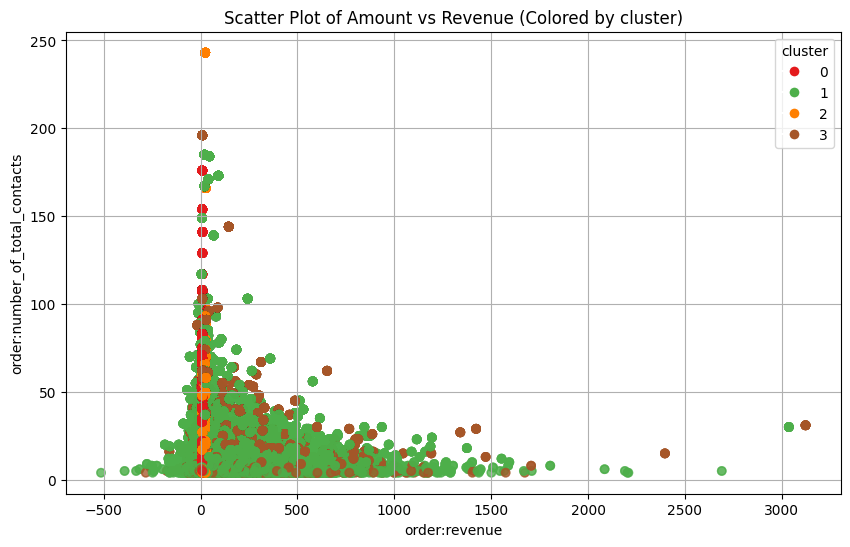

In [54]:
MyScatterplot(df, 'order:revenue', 'order:number_of_total_contacts', 'cluster', cmap='Set1', alpha=0.3)

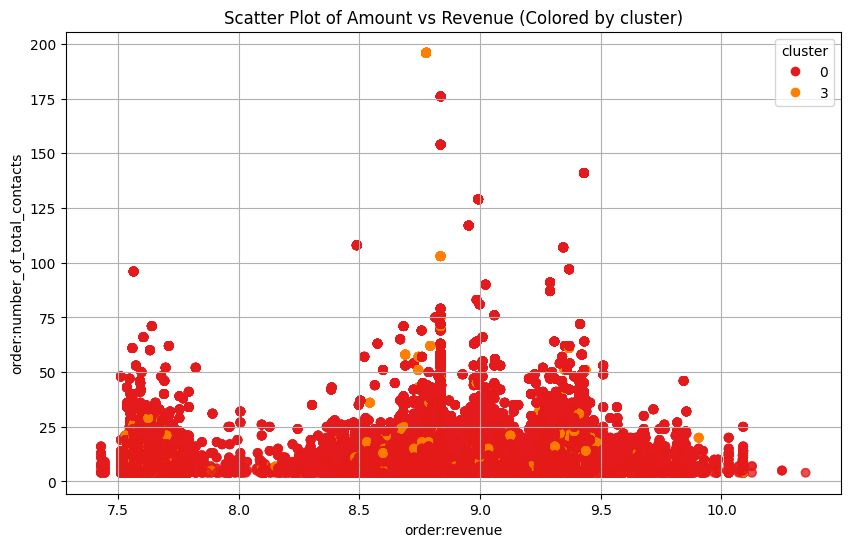

In [55]:
MyScatterplot(df[
    (df['order:partner']=='Partner A')
], 'order:revenue', 'order:number_of_total_contacts', 'cluster', cmap='Set1', alpha=0.3)

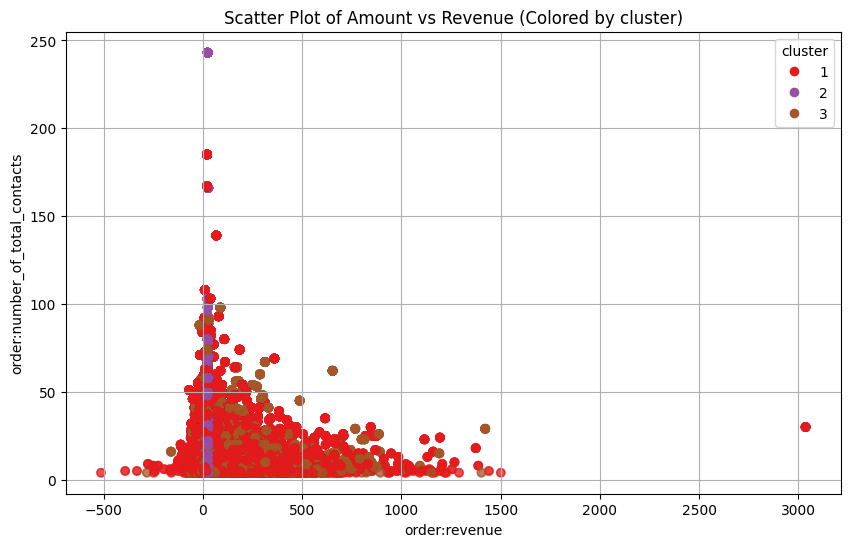

In [56]:
MyScatterplot(df[
    (df['order:partner']=='Partner C')
], 'order:revenue', 'order:number_of_total_contacts', 'cluster', cmap='Set1', alpha=0.3)

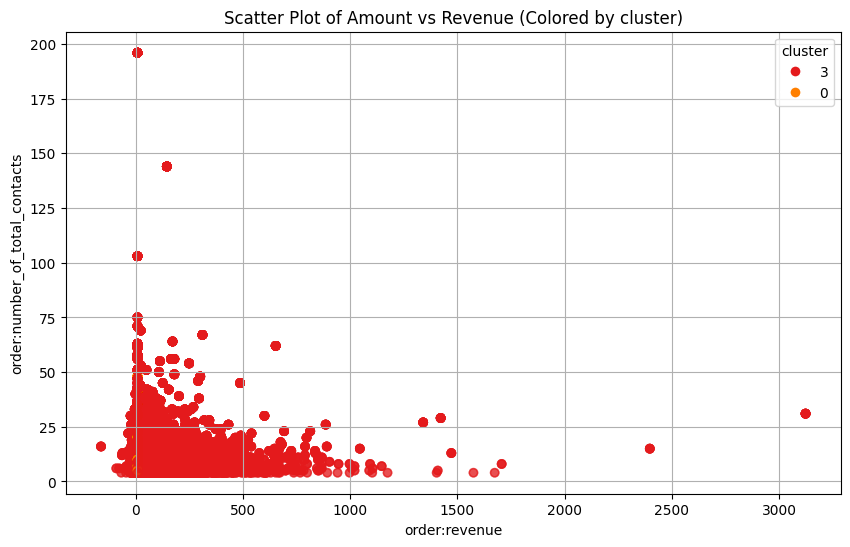

In [57]:
MyScatterplot(df[
    (df['order:num_of_pnr']>2)
], 'order:revenue', 'order:number_of_total_contacts', 'cluster', cmap='Set1', alpha=0.3)


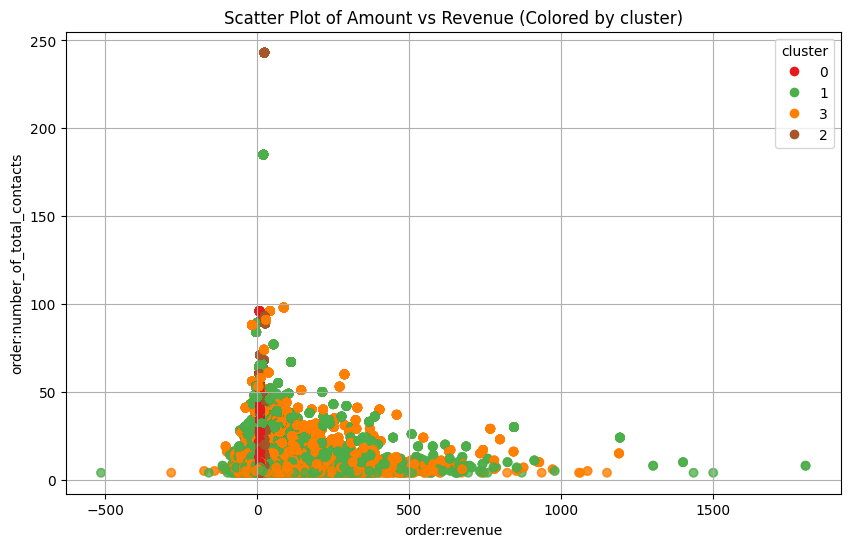

In [58]:
MyScatterplot(df[
    (df['order:num_of_pnr']==2)
], 'order:revenue', 'order:number_of_total_contacts', 'cluster', cmap='Set1', alpha=0.3)


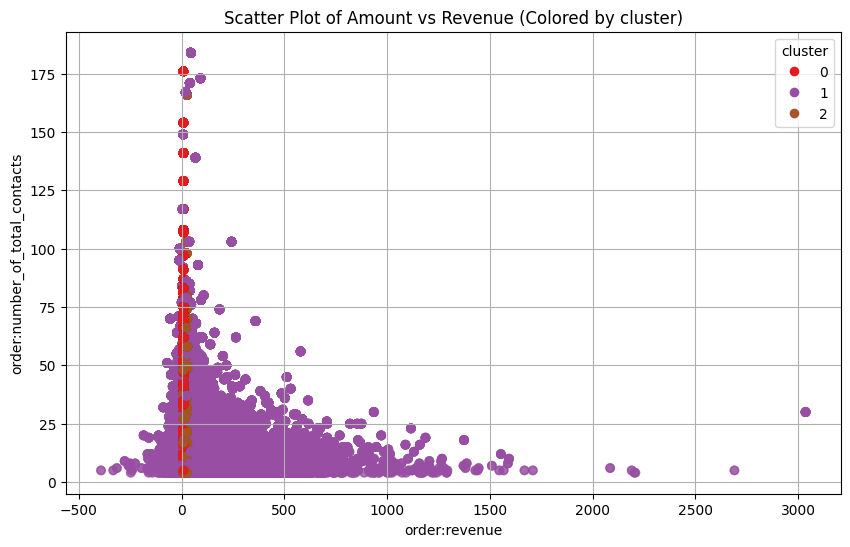

In [59]:
MyScatterplot(df[
    (df['order:num_of_pnr']==1)
], 'order:revenue', 'order:number_of_total_contacts', 'cluster', cmap='Set1', alpha=0.3)


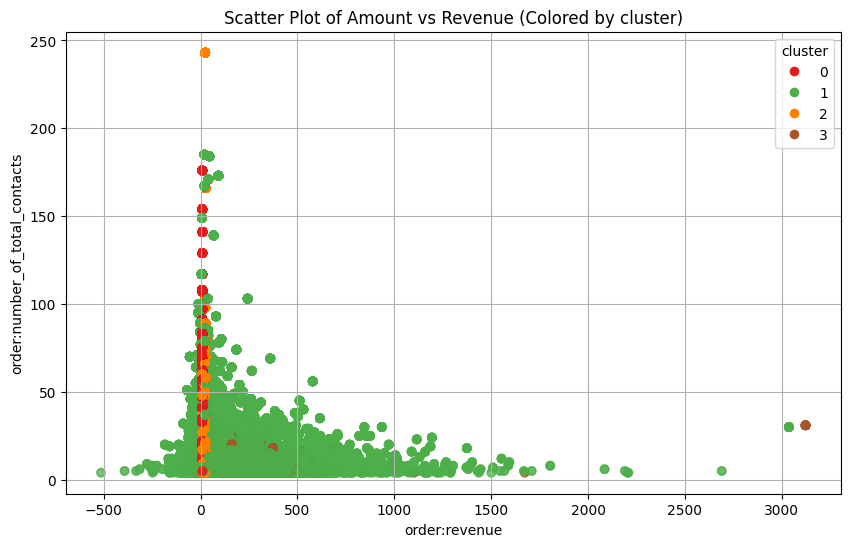

In [60]:
MyScatterplot(df[
    (df['order:num_of_booking_system']==1)
], 'order:revenue', 'order:number_of_total_contacts', 'cluster', cmap='Set1', alpha=0.3)

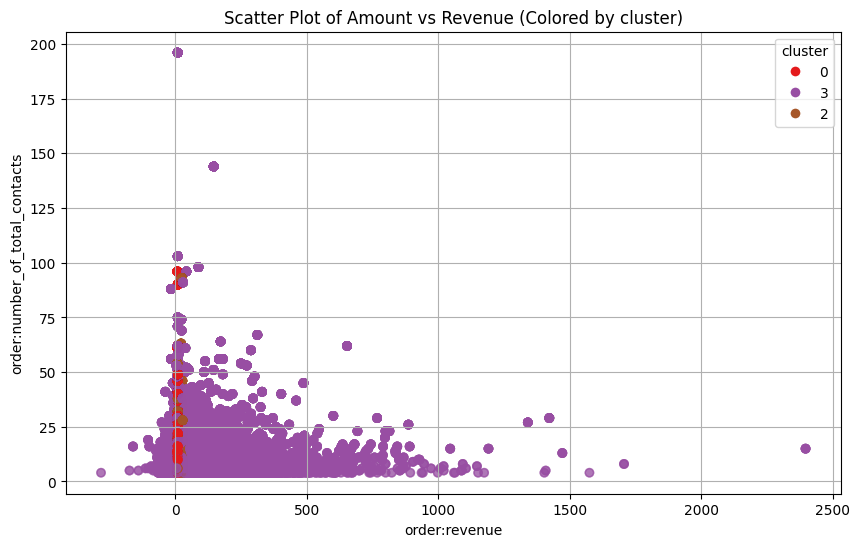

In [61]:
MyScatterplot(df[
    (df['order:num_of_booking_system']>1)
], 'order:revenue', 'order:number_of_total_contacts', 'cluster', cmap='Set1', alpha=0.3)

After performing the clustering on Production data, we can conclude that: 
   
* Despite the range of number of contacts has not changed much, the revenue differes significantly. This means that we may be able to optimize process for Partner A as they cause the same number of contact

The process may also be optimzied by number of booking systems, but the significanyt is not as high as what we tested based on sample data. More data is needed for such conclusion. 